## Семинар: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook

plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

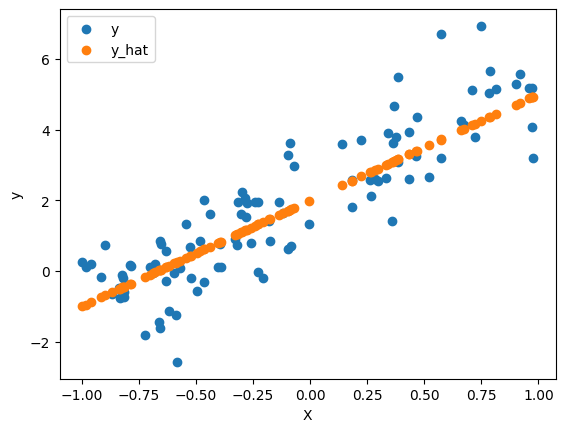

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

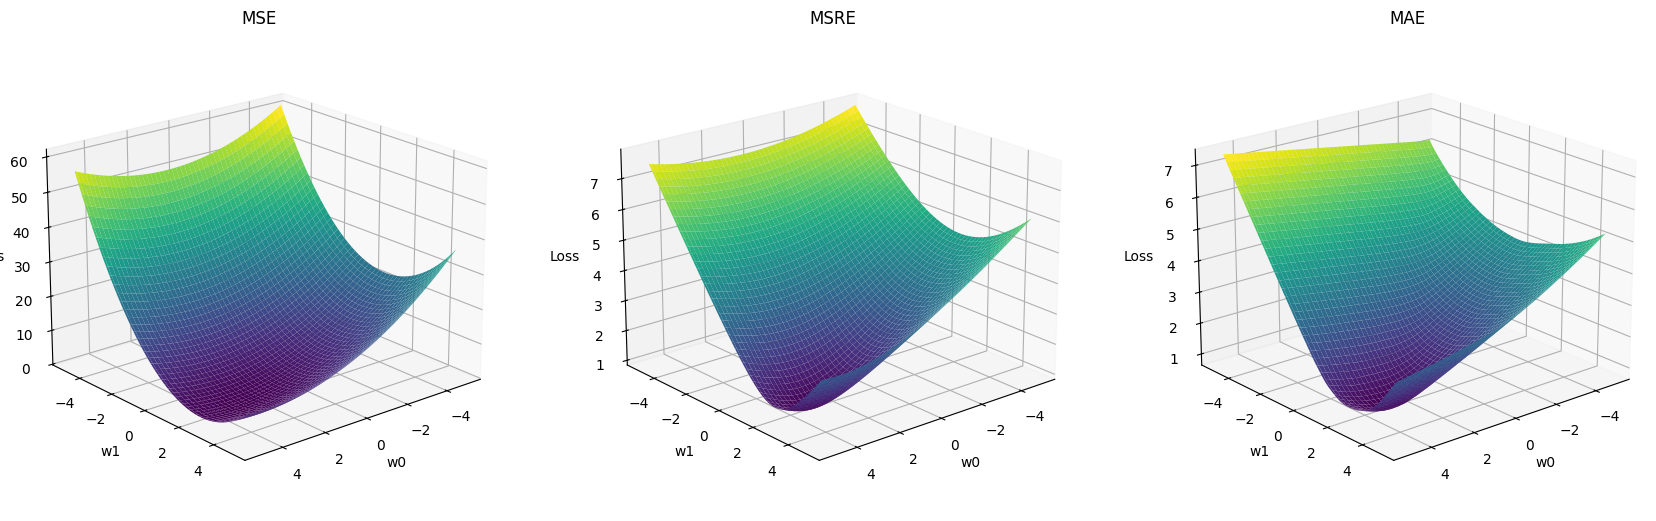

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [13]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-09-30 19:17:31--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-09-30 19:17:31--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [              <=>   ]  33.20M  10.0MB/s    in 3.9s    

2025-09-30 19:17:35 (8.48 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [16]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [17]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-08):
        super().__init__(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps

        self.iter = 0
        self.G = [torch.zeros_like(p) for p in self.params]
        self.prev_momentum = [torch.zeros_like(p) for p in self.params]

    @torch.no_grad()
    def step(self):
        self.iter += 1

        for i, p in enumerate(self.params):
            if p.grad is None:
                continue

            beta1, beta2 = self.betas
            self.prev_momentum[i] = beta1 * self.prev_momentum[i] + (1 - beta1) * p.grad
            self.G[i] = beta2 * self.G[i] + (1 - beta2) * (p.grad) ** 2

            momentum_hat = self.prev_momentum[i] / (1 - beta1 ** self.iter)
            G_hat = self.G[i] / (1 - beta2 ** self.iter)
            p -= self.lr * momentum_hat / (torch.sqrt(G_hat) + self.eps)

In [24]:
class AdamW(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.iter = 0
        self.G = [torch.zeros_like(p) for p in self.params]
        self.prev_momentum = [torch.zeros_like(p) for p in self.params]

    @torch.no_grad()
    def step(self):
        self.iter += 1
        for i, p in enumerate(self.params):

            if p.grad is None:
                continue

            beta1, beta2 = self.betas
            p -= self.lr * self.weight_decay * p

            self.prev_momentum[i] = beta1 * self.prev_momentum[i] + (1 - beta1) * p.grad
            self.G[i] = beta2 * self.G[i] + (1 - beta2) * (p.grad) ** 2

            momentum_hat = self.prev_momentum[i] / (1 - beta1 ** self.iter)
            G_hat = self.G[i] / (1 - beta2 ** self.iter)
            p -= self.lr * momentum_hat / (torch.sqrt(G_hat) + self.eps)

In [19]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [68]:
import math
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.last_epoch = -1
        self.base_lr = optimizer.lr

    def step(self):
        self.last_epoch += 1

        if self.last_epoch >= self.total_iters:
            return

        progress = self.last_epoch / self.total_iters
        factor = self.start_factor + (self.end_factor - self.start_factor) * progress

        self.optimizer.lr = factor * self.base_lr


class CosineAnnealingLR(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.last_epoch = -1

    def step(self):
        self.last_epoch += 1
        t = self.last_epoch

        if t >= self.T_max:
            return

        cosine_factor = (1 + math.cos(math.pi * (t + 1) / self.T_max)) / (1 + math.cos(math.pi * t / self.T_max))
        self.optimizer.lr = self.eta_min + (self.optimizer.lr - self.eta_min) * cosine_factor

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, optimizer, criterion, scheduler=None):
    model.train()
    train_losses, test_losses = [], []
    train_accuracy, test_accuracy = [], []

    for epoch in tqdm(range(5)):
        train_loss = 0
        predictions = []
        labels = []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            y_pred = model(x)
            loss = criterion(y_pred, y)
            train_loss += loss.detach().cpu().item()
            predictions.extend(y_pred.argmax(dim=-1).detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy.append((np.array(labels) == np.array(predictions)).mean())

        model.eval()
        with torch.inference_mode():
            test_loss = 0
            predictions = []
            labels = []

            for x, y in test_loader:
                x, y = x.to(device), y.to(device)

                y_pred = model(x)
                loss = criterion(y_pred, y)
                test_loss += loss.detach().cpu().item()
                predictions.extend(y_pred.argmax(dim=-1).detach().cpu().numpy())
                labels.extend(y.detach().cpu().numpy())

            test_loss /= len(test_loader)
            test_losses.append(test_loss)
            test_accuracy.append((np.array(labels) == np.array(predictions)).mean())

        if scheduler:
            scheduler.step()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_losses, label="Train Loss", marker='o')
    ax1.plot(test_losses, label="Test Loss", marker='o')
    ax1.set_title("Loss")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accuracy, label="Train Accuracy", marker='o')
    ax2.plot(test_accuracy, label="Test Accuracy", marker='o')
    ax2.set_title("Accuracy")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

100%|██████████| 5/5 [01:28<00:00, 17.79s/it]


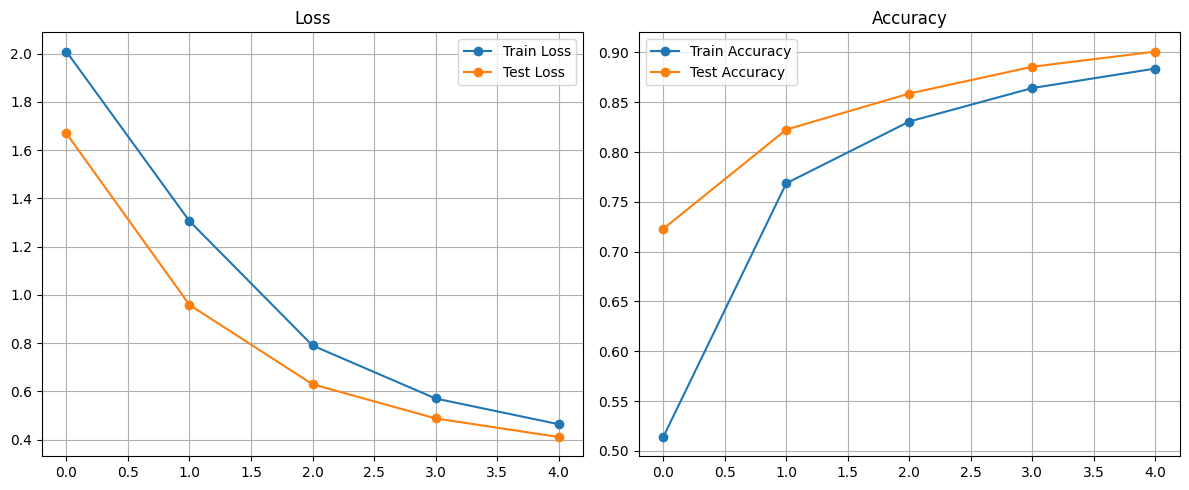

In [51]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)

train(model, SGD(params=model.parameters(), lr=3e-4), nn.CrossEntropyLoss())

100%|██████████| 5/5 [01:39<00:00, 19.92s/it]


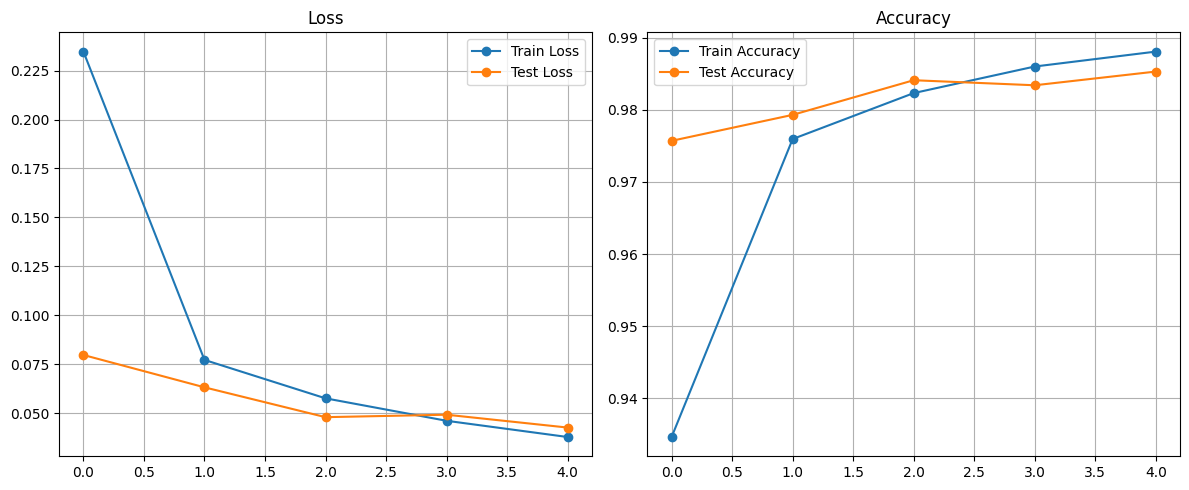

In [54]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)

train(model, Adam(params=model.parameters(), lr=3e-4), nn.CrossEntropyLoss())

100%|██████████| 5/5 [01:39<00:00, 19.88s/it]


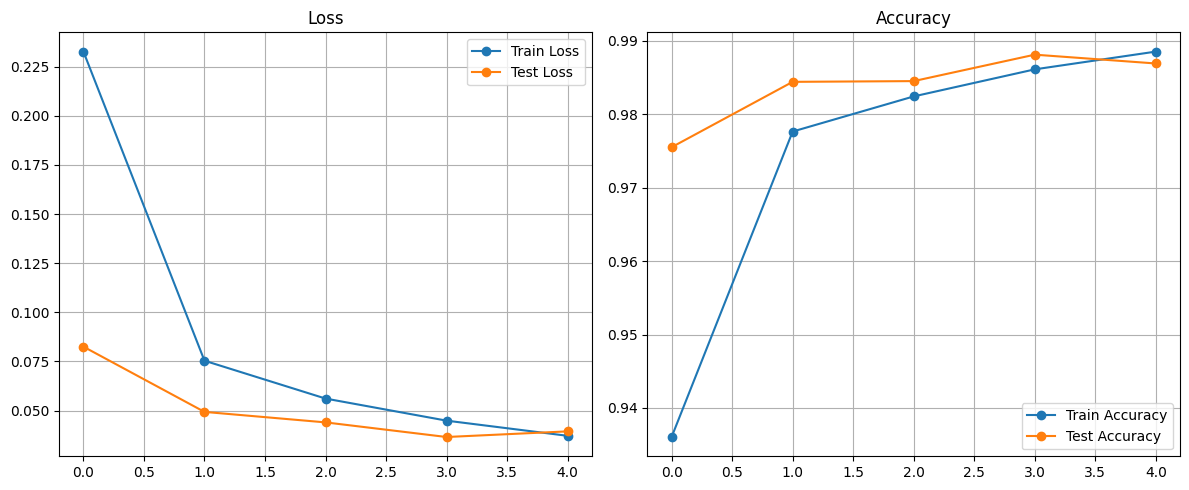

In [55]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)

train(model, AdamW(params=model.parameters(), lr=3e-4), nn.CrossEntropyLoss())

Adam и AdamW показали результат лучше SGD. AdamW показал лучший результат на тестовой выборке.

100%|██████████| 5/5 [01:34<00:00, 18.82s/it]


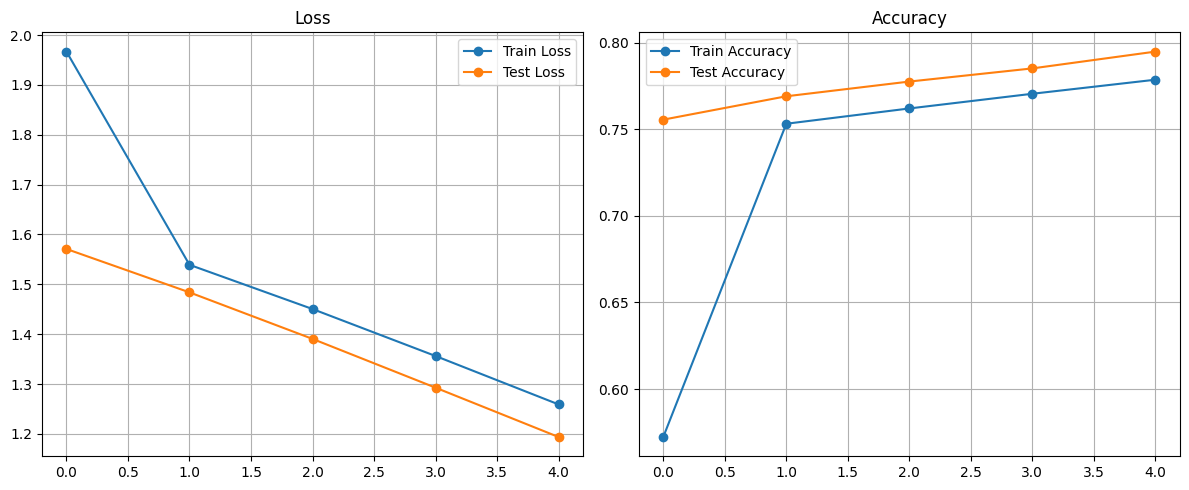

In [61]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)
optimizer = SGD(params=model.parameters(), lr=3e-4)
train(model, optimizer, nn.CrossEntropyLoss(), scheduler=LinearLR(optimizer))

100%|██████████| 5/5 [01:23<00:00, 16.71s/it]


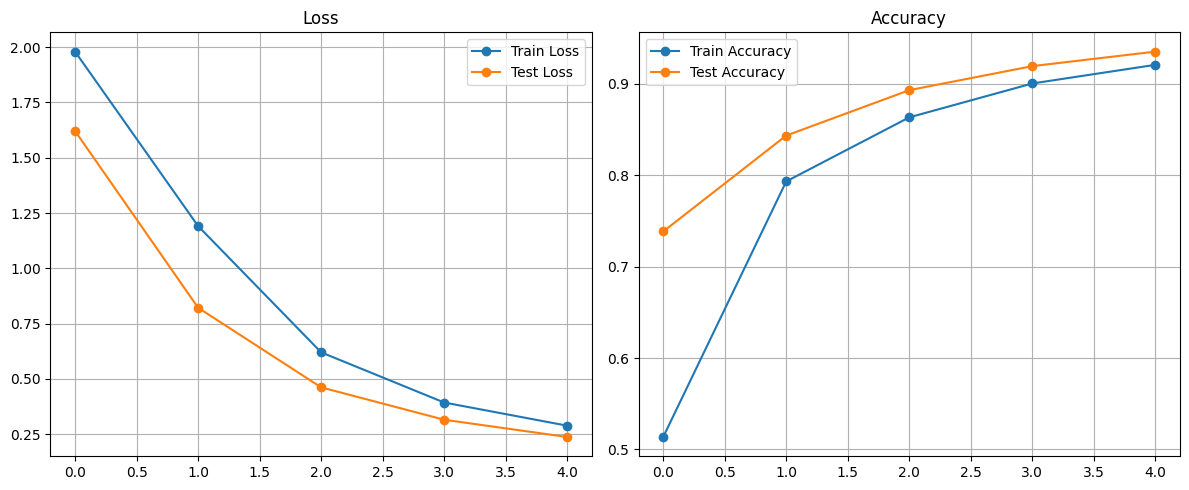

In [69]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)
optimizer = SGD(params=model.parameters(), lr=3e-4)
train(model, optimizer, nn.CrossEntropyLoss(), scheduler=CosineAnnealingLR(optimizer))

100%|██████████| 5/5 [01:29<00:00, 17.93s/it]


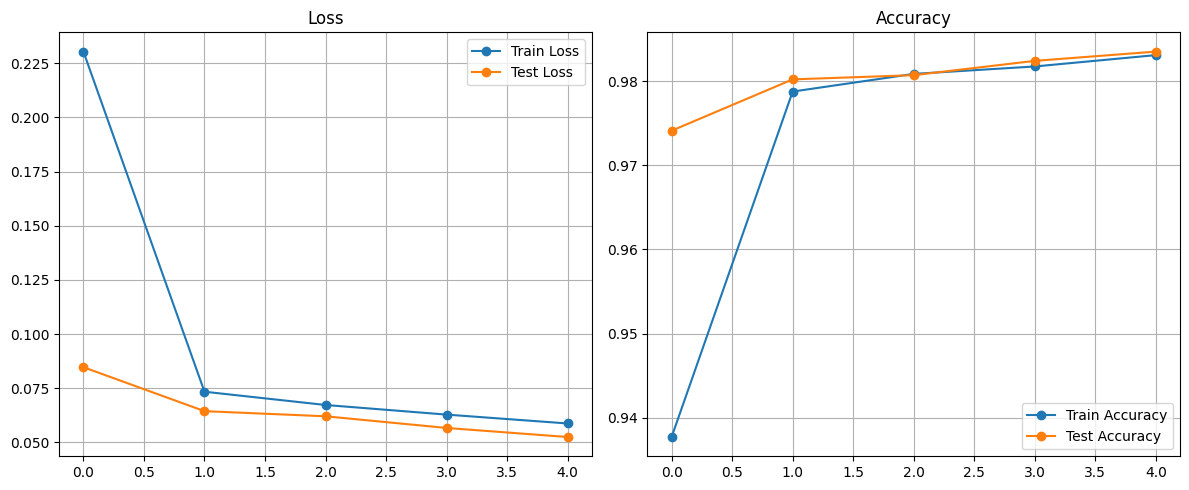

In [64]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)
optimizer = Adam(params=model.parameters(), lr=3e-4)
train(model, optimizer, nn.CrossEntropyLoss(), scheduler=LinearLR(optimizer))

100%|██████████| 5/5 [01:30<00:00, 18.04s/it]


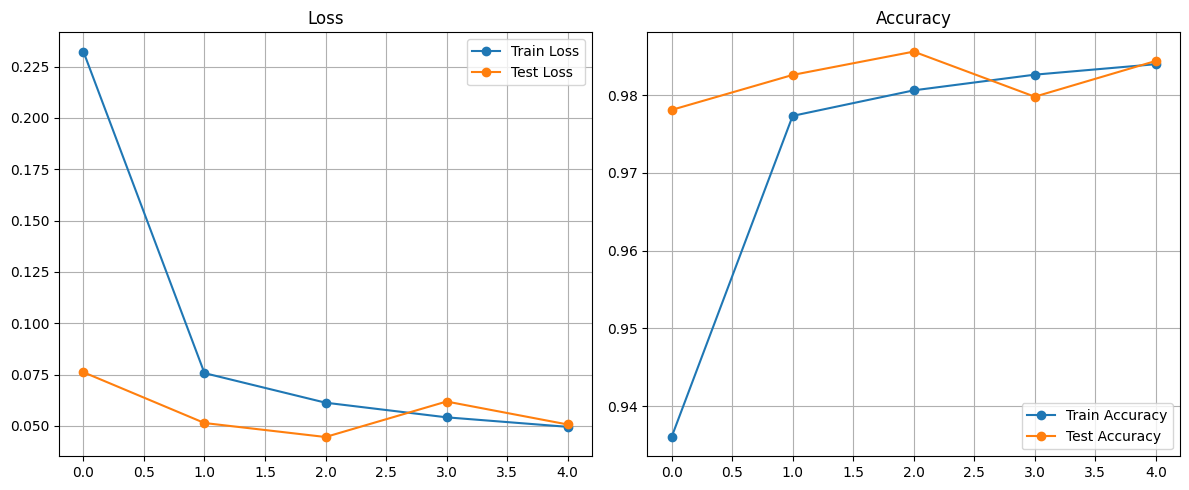

In [70]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)
optimizer = Adam(params=model.parameters(), lr=3e-4)
train(model, optimizer, nn.CrossEntropyLoss(), scheduler=CosineAnnealingLR(optimizer))

100%|██████████| 5/5 [01:31<00:00, 18.37s/it]


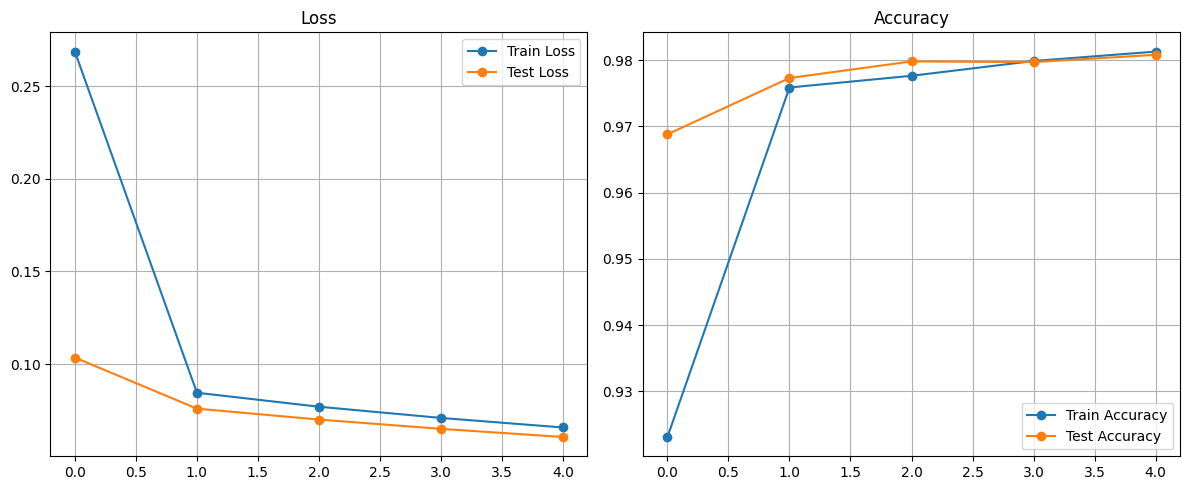

In [66]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)
optimizer = AdamW(params=model.parameters(), lr=3e-4)
train(model, optimizer, nn.CrossEntropyLoss(), scheduler=LinearLR(optimizer))

100%|██████████| 5/5 [01:32<00:00, 18.47s/it]


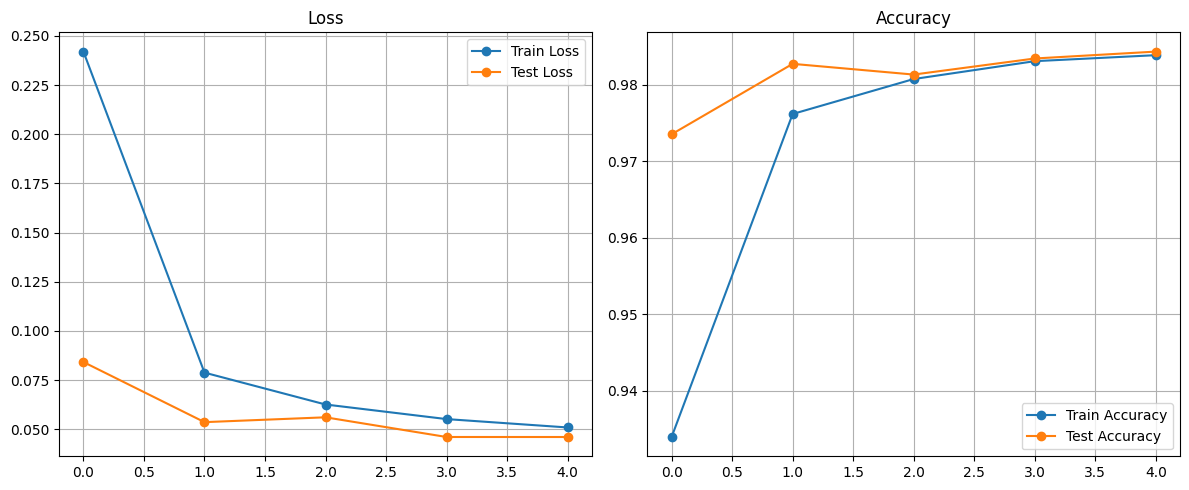

In [71]:
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

model.to(device)
optimizer = AdamW(params=model.parameters(), lr=3e-4)
train(model, optimizer, nn.CrossEntropyLoss(), scheduler=CosineAnnealingLR(optimizer))

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here